# Data Generation for Car Loan Use Case
This notebook reports the steps to generate data folowing custom trends, applied on the Car Loan use case. There are three main parts:
* The first part is to generate data that folows a custom trend in general, including the possibility to specify what % a particular in-/decrease should be.
* The second part is to apply these tools on the Car Loan use case and to generate custom data for all Car Loan widgets.
* The third part is to ingest the data into Lily. The data is visualized in this local environment to have quicker feedback on code changes, but of course has to be ingested into Lily eventually.

# 0. Visualization Tools

These are some preparation tools just for the sake of visualization in this notebook. Basically, we can now aggregate and visualize data, grouped in databins. This part can be skipped.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

In [2]:
databins = ['2016-01-01', '2016-01-15', '2016-02-01', '2016-02-15', '2016-03-01', '2016-03-15',
            '2016-04-01', '2016-04-15', '2016-05-01', '2016-05-15', '2016-06-01', '2016-06-15',
            '2016-07-01', '2016-07-15', '2016-08-01', '2016-08-15', '2016-09-01', '2016-09-15',
            '2016-10-01', '2016-10-15', '2016-11-01', '2016-11-15', '2016-12-01']
databinsZ = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
            '2016-01-01', '2017-01-01']
databinsF = ['2016-11-30', '2017-11-30', '2018-11-30', '2019-11-30', '2020-11-30', '2021-11-30',
            '2022-11-30', '2023-11-30']
ticks = ('1/16', '2/16', '3/16', '4/16', '5/16', '6/16', '7/16', '8/16', '9/16', '10/16', '11/16', '12/16')

In [3]:
def createBins(df, databins, column='START', cumulative=True):
    if cumulative:
        return np.array([len(df[df.loc[:,column] < databins[i]]) for i in range(len(databins)-1)], dtype=float)
    return np.array([len(df[(df.END > databins[i]) & (df.END < databins[i+1])]) for i in range(len(databins)-1)])

# 1. Data Generation Tools
This part is about generating data that folows a custom trend in general. When the needed trend is constant, or increasing or decreasing in a consistent manner, this can be solved quite easily. When a more complex trend is needed, however, it is convenient to provide a function that accounts for any particularities in that trend.

### 1.1 Create Functions
These are four arbitrary functions for the sake of demonstration, visualized below.

In [4]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def peak(x):
    xPoints = (np.array([-6*365, 0, 1, 150, 180, 210, 365]) + 6*365) / (7*365.)
    yPoints = np.array([0, 2, 2, 2, 50, 2, 2]) / 50.
    i = interp1d(xPoints, yPoints)
    return i(x)

functions = [logit, gauss, winner, peak]

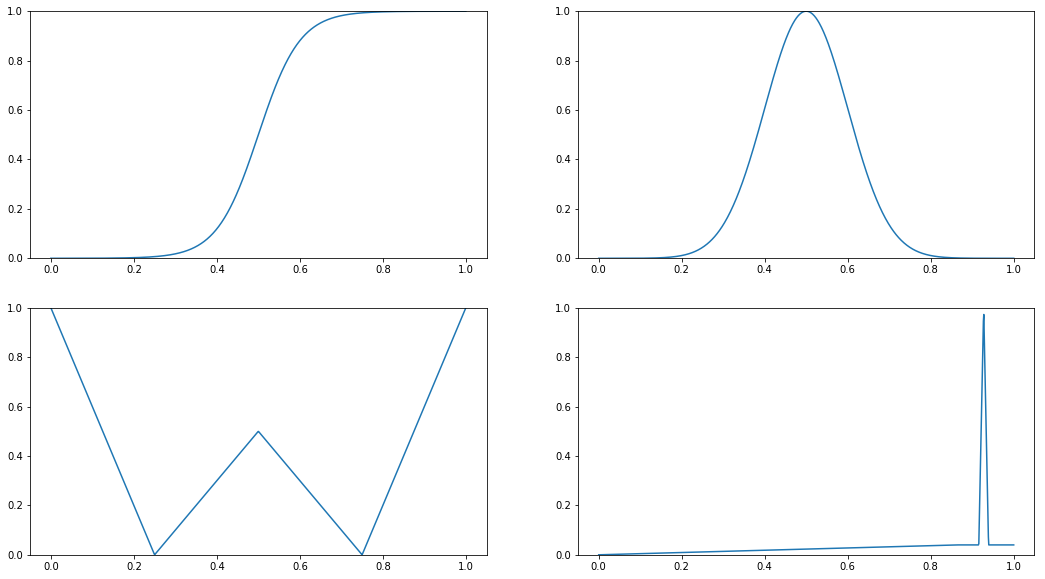

In [5]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i)
    ax.plot(x, f(x))
    plt.ylim(0,1)
plt.show()

### 1.2 Create Distributions

Here, 10000 random numbers are generated for every function. When plotted in a histogram, their distributions clearly folow the respective functions. The take-away message here is that any trend should be describable.

In [6]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

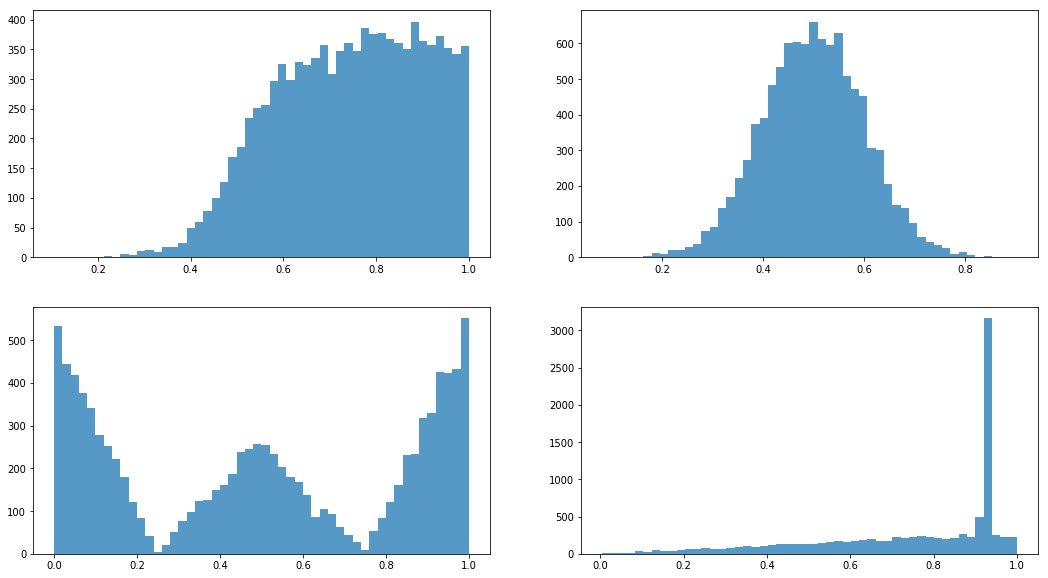

In [7]:
fig, axs = plt.subplots(2,2, figsize=(18, 10))
for i, (f, ax) in enumerate(zip(functions, axs.flatten())):
    picks = generateDistribution(f, 10000)
    ax.hist(picks, bins=50, alpha=0.75)
plt.show()

### 1.3 Retrieve Percentage of Increase
With respect to a use case, it would be convenient to play around with percentages by which a trend should increase or decrease for a specified period of time. Eg. a 30% increase of the clients' volume in 2016. Say we have a trend as folows, with the distribution shown cumulatively.

In [8]:
xPoints = (np.arange(5) / 4.)
yPoints = np.array([0, 50, 0, 20, 0]) / 50.
i = interp1d(xPoints, yPoints)

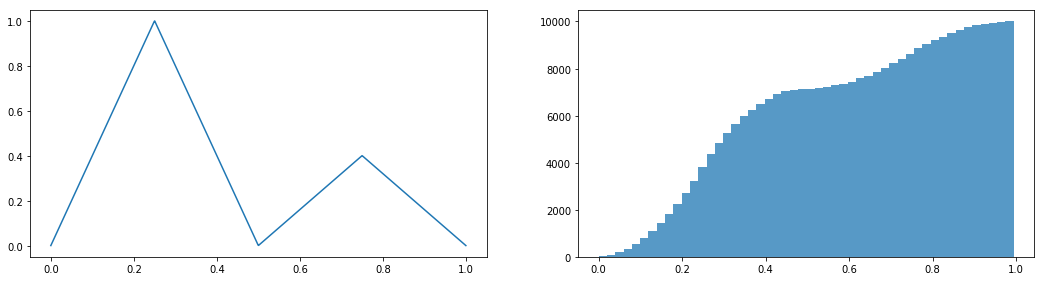

In [9]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax1.plot(x, i(x))
picks = generateDistribution(i, 10000)
ax2 = fig.add_subplot(222)
ax2.hist(picks, bins=50, alpha=0.75, cumulative=True)
plt.show()

Then by means of integrals we can calculate what the percentage is of the first large increase.

In [10]:
from scipy.integrate import quad
def percentageIncrease(function, start=0, end=1):
    totalSurface = quad(function, 0., 1.)[0]
    periodSurface = quad(function, start, end)[0]
    return periodSurface / totalSurface

In [11]:
print(percentageIncrease(i))
print(percentageIncrease(i, 0, .5))
print(percentageIncrease(i, .5, 1))

1.0
0.714285714286
0.285714285714


So the first increase in the trend is accountible for about 71% of the data. We can verify in the plot that is just about the case.

### 1.4 Add Random Noise

Generally, trends do not follow straight lines. To account for this, some random jitter should be added, as illustrated below.

In [12]:
def noise(x, c=1):
    n = np.random.randint(5, 20)
    r = [np.random.randint(20, 80) for _ in range(n*2)]
    jitter = 0
    for i in range(n):
        jitter += np.sin(r[i]*x) / float(r[i+1])
    return c * jitter

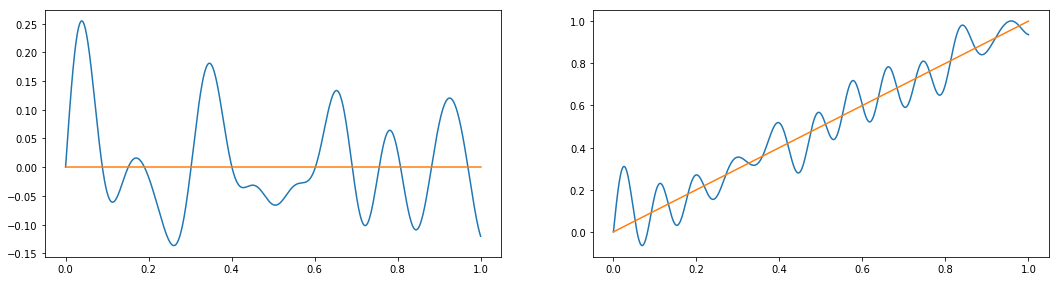

In [13]:
x = np.linspace(0,1, num=1001)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(x, noise(x), x, np.zeros(len(x)))
ax2.plot(x, x+noise(x), x, x)
plt.show()

# 2. Car Loan Data Generation - Entities
The goal is now to apply these building stones on the car loan use case. A configuration of Lily contains scripts to generate the data, and will now contain some of the code above. Below, the data is loaded to verify its trends, and to tweak the scripts if necessary.

In [127]:
path = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/EntityDataAll.csv'
#path = '/Users/desiredewaele/Desktop/EntityDataAll.csv'
productData = pd.read_csv(path, sep=';', index_col=0)

In [128]:
productData.head()

,ID,PRODUCT,WAARDE,START,END,TYPE,SUBTYPE,ACTIF,MARGIN,RATE,CREDIT
ENTITY_ID,,,,,,,,,,,
1000001001,1,Checking Account,5039.308208,2016-06-29,2026-06-27,Checking Account,NaN,True,NaN,NaN,NaN
2000001001,1,Credit Card,NaN,2016-06-25,2026-06-23,Credit Card,NaN,True,NaN,NaN,NaN
4000001001,1,Savings Account,644524.388968,2013-05-12,2023-05-10,Savings Account,NaN,True,NaN,NaN,NaN
5000001001,1,Mutual Funds,12356.418741,2016-09-07,2026-09-05,Mutual Funds,NaN,True,NaN,NaN,NaN
6000001001,1,Bond Products,20213.235453,2012-11-19,2022-11-17,Bond Products,NaN,True,NaN,NaN,NaN


In [129]:
print productData.START.iloc[0]
print productData.END.iloc[0]

2016-06-29
2026-06-27


In [130]:
productData[productData.PRODUCT == 'Car Loan'].sort_values('ID').head()

,ID,PRODUCT,WAARDE,START,END,TYPE,SUBTYPE,ACTIF,MARGIN,RATE,CREDIT
ENTITY_ID,,,,,,,,,,,
15000002001,2,Car Loan,33778.139993,2014-12-25,2018-03-01,Car Loan,NaN,True,2.506446,4.266551,27338.473451
15000010001,10,Car Loan,33400.823068,2015-02-17,2019-05-01,Car Loan,NaN,True,2.089346,4.145834,28312.387226
15000011001,11,Car Loan,34197.300975,2015-11-11,2017-06-30,Car Loan,NaN,True,2.623629,4.354013,27882.477901
15000015001,15,Car Loan,34278.807019,2016-06-28,2017-06-01,Car Loan,NaN,True,2.749605,4.525171,29778.882829
15000020001,20,Car Loan,34252.359551,2016-12-09,2018-06-24,Car Loan,NaN,True,3.136173,4.251716,29752.028926


In [126]:
productData.loc[:,'START'] = productData.START.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
productData.loc[:,'END'] = productData.END.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
print(len(productData))
productData.head()

ValueError: unconverted data remains:  07:12:23.103947

Here, some records are shown for illustration.

In [97]:
activeCarLoans = productData[productData.PRODUCT == 'Car Loan']
print(len(activeCarLoans))
activeCarLoans.head()

2641


,ID,PRODUCT,WAARDE,START,END,TYPE,SUBTYPE,ACTIF,MARGIN,RATE,CREDIT
ENTITY_ID,,,,,,,,,,,
15000002001,2,Car Loan,33778.139993,2014-12-25,2018-03-01,Car Loan,NaN,True,2.506446,4.266551,27338.473451
15000010001,10,Car Loan,33400.823068,2015-02-17,2019-05-01,Car Loan,NaN,True,2.089346,4.145834,28312.387226
15000011001,11,Car Loan,34197.300975,2015-11-11,2017-06-30,Car Loan,NaN,True,2.623629,4.354013,27882.477901
15000015001,15,Car Loan,34278.807019,2016-06-28,2017-06-01,Car Loan,NaN,True,2.749605,4.525171,29778.882829
15000020001,20,Car Loan,34252.359551,2016-12-09,2018-06-24,Car Loan,NaN,True,3.136173,4.251716,29752.028926


## 2.1 Widget 1: Car Loans & Savings Accounts Share of Wallet

In [98]:
activeCarLoans = productData[productData.PRODUCT == 'Car Loan']
activeAccounts = productData[productData.PRODUCT == 'Savings Account']
activeCustomers = productData[productData.groupby(['ID'])['START'].transform(min) == productData['START']]

In [99]:
carLoansInTime = createBins(activeCarLoans, databins)
accountsInTime = createBins(activeAccounts, databins)
activesInTime = createBins(activeCustomers, databins)

In [100]:
carLoansShare = carLoansInTime / activesInTime
accountsShare = accountsInTime / activesInTime

The plots below show the car loans, savings accounts and active customers over time (left) and the share of car loans and savings accounts (right).

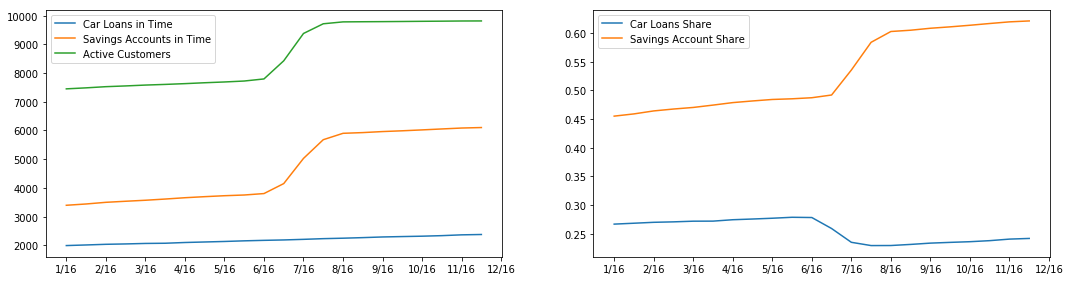

In [102]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, carLoansInTime, label='Car Loans in Time')
ax1.plot(x, accountsInTime, label='Savings Accounts in Time')
ax1.plot(x, activesInTime, label='Active Customers')
ax2.plot(x, carLoansShare, label='Car Loans Share')
ax2.plot(x, accountsShare, label='Savings Account Share')
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
ax1.legend(); ax2.legend()
plt.show()

These are the percentage checks.

In [103]:
print 'Increase of total active customers in 2016. Should be 30%:', activesInTime[-1] / float(activesInTime[0])-1
print 'Car Loans Share of Wallets pre 2016. Should be 30%:', carLoansInTime[0] / float(activesInTime[0])
print 'Car Loans Share of Wallets post 2016. Should be 25%:', carLoansInTime[-1] / float(activesInTime[-1])
print 'Savings Accounts Share of Wallets pre 2016. Should be 50%:', accountsInTime[0] / float(activesInTime[0])
print 'Savings Accounts Share of Wallets post 2016. Should be 61%:', accountsInTime[-1] / float(activesInTime[-1])

Increase of total active customers in 2016. Should be 30%: 0.317809689974
Car Loans Share of Wallets pre 2016. Should be 30%: 0.266675614012
Car Loans Share of Wallets post 2016. Should be 25%: 0.241674304919
Savings Accounts Share of Wallets pre 2016. Should be 50%: 0.455240907261
Savings Accounts Share of Wallets post 2016. Should be 61%: 0.621448212649


## 2.2 Widget 2: Evolution of Rate and Margin
The left plot shows the function used to generate data from, the right plot visualizes the actual data over time.

In [104]:
# FUNCTIONS
xPoints = (np.array([-6*365, -5*365, 0, 365]) + 6*365) / (7*365.)
yPoints1 = np.array([5.5, 5.5, 4, 4.5])
yPoints2 = np.array([3.5, 3.5, 2.5, 3])
rate = interp1d(xPoints, yPoints1)
margin = interp1d(xPoints, yPoints2)

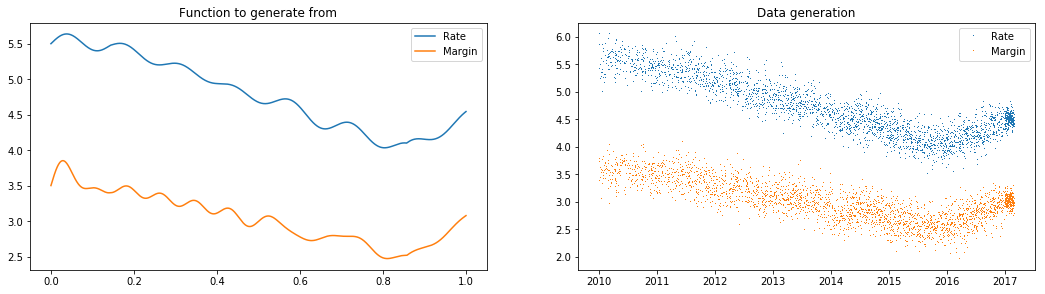

In [105]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, rate(x) + noise(x), label='Rate'); ax1.plot(x, margin(x) + noise(x), label='Margin')
ax2.plot(activeCarLoans.START, activeCarLoans.RATE, ',', label='Rate')
ax2.plot(activeCarLoans.START, activeCarLoans.MARGIN, ',', label='Margin')
ax1.legend(); ax2.legend()
ax1.set_title('Function to generate from')
ax2.set_title('Data generation')
plt.show()

## 2.3 Widget 3: Evolution of Value and Credit

The left plot shows the function used to generate data from, the right plot visualizes the actual data over time.

In [106]:
# FUNCTIONS
xPoints = (np.array([-6*365, -5*365, 365]) + 6*365) / (7*365.)
yPoints1 = np.array([30000, 30000, 35000])
yPoints2 = np.array([25000, 25000, 30000])
value = interp1d(xPoints, yPoints1)
credit = interp1d(xPoints, yPoints2)

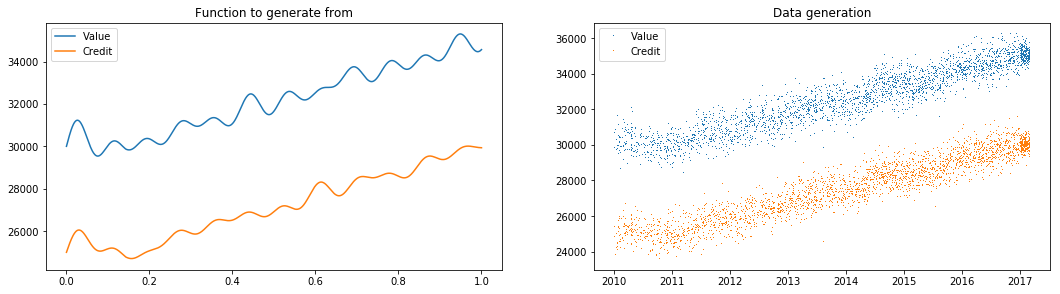

In [107]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, value(x) + noise(x, 3000), label='Value'); ax1.plot(x, credit(x) + noise(x, 3000), label='Credit')
ax2.plot(activeCarLoans.START, activeCarLoans.WAARDE, ',', label='Value')
ax2.plot(activeCarLoans.START, activeCarLoans.CREDIT, ',', label='Credit')
ax1.legend(); ax2.legend()
ax1.set_title('Function to generate from')
ax2.set_title('Data generation')
plt.show()

## 2.4 Widget 4: Age Buckets of Car Loans

The pie chart below shows the remaining car loan durations. 

In [26]:
def endDate():
    years = np.random.choice(np.arange(7), p=np.array([23, 25, 17, 12, 13, 6, 4]) / 100.)
    return (years + np.random.uniform()) * 365
picks = np.array([endDate() for _ in range(50000)])

In [27]:
carLoansInFuture = createBins(activeCarLoans, databinsF, cumulative=False)
print carLoansInFuture

[2955 3223 2253 1683 1687  903  630]


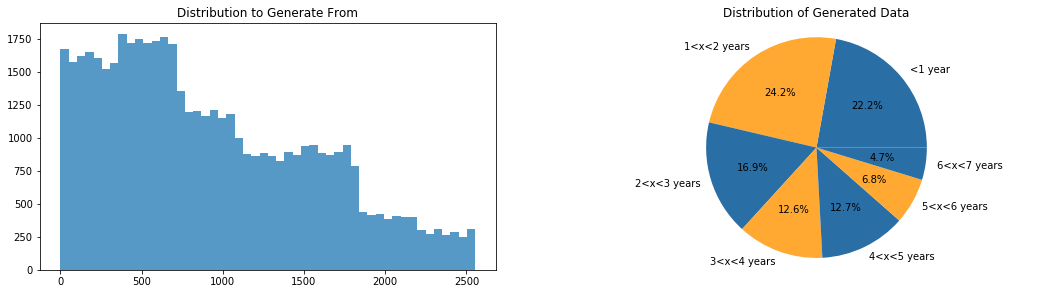

In [28]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.hist(picks, bins=50, alpha=0.75, cumulative=False)
ax1.set_title('Distribution to Generate From')

labels = '<1 year', '1<x<2 years', '2<x<3 years', '3<x<4 years', '4<x<5 years', '5<x<6 years', '6<x<7 years'
ax2.pie(carLoansInFuture, labels=labels, colors=('#2A6EA6', '#FFA933'), autopct='%1.1f%%')
ax2.axis('equal'); ax2.set_title('Distribution of Generated Data')
plt.show()

# 3. Car Loan Data Generation - Interactions

## Script

In [135]:
basepath = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/'
itxfile = 'ItxData_PM_CallCenter_2016-09-12_2017-03-12.csv'
names = pd.read_csv(basepath+'ItxData_PM_CallCenter_2016-09-12_2017-03-12.hdr', sep=';')
carloans = pd.read_csv(basepath+itxfile, sep=';', names=names)
carloans.loc[:,'date'] = carloans.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
#carloans.loc[:,'time'] = carloans.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
carloans.loc[:,'time'] = carloans.time.apply(lambda x: striptime(x))

#carloans['dayOfYear'] = carloans.date.map(lambda x: int(x.strftime('%j')) - 1)

In [137]:
carloans.head()

,id,itxseq,date,time,goal,subgoal,channel,amount,accountType
0,1,26,2016-12-25,06:55:13,manage product portfolio,close an existing account,Call Center,1,money market
1,1,34,2016-12-16,20:11:06,manage product portfolio,apply for a new account,Call Center,1,auto
2,1,40,2016-10-08,11:54:55,manage product portfolio,close an existing account,Call Center,1,savings
3,1,86,2016-10-15,18:32:08,manage product portfolio,close an existing account,Call Center,1,savings
4,1,94,2017-02-05,15:15:30,manage product portfolio,apply for a new account,Call Center,1,mortgage


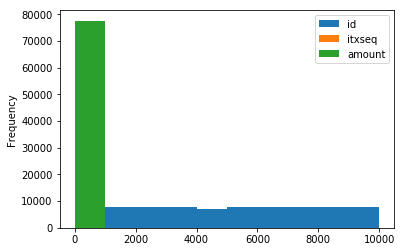

In [151]:
%matplotlib inline
carloans.plot('time', kind='hist')

In [139]:
hours = carloans.time.values
hours

array([datetime.time(6, 55, 13), datetime.time(20, 11, 6),
       datetime.time(11, 54, 55), ..., datetime.time(13, 10, 25),
       datetime.time(20, 33, 5), datetime.time(14, 17, 19)], dtype=object)

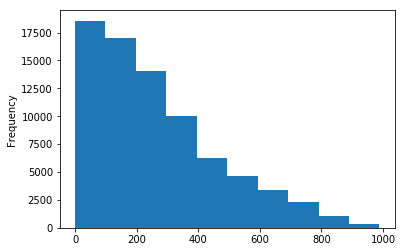

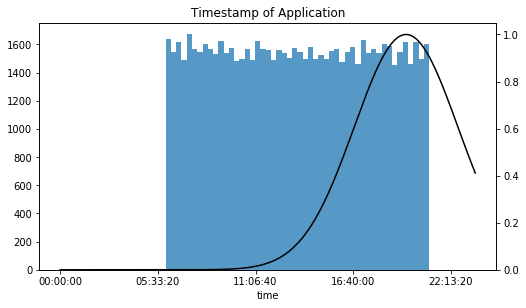

In [140]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax4.plot(x*85000, timestamp(x), '-k')
ax3.hist(hours, bins=50, alpha=0.75)

ax3.set_title('Timestamp of Application')
ax4.set_ylim(0,)
plt.show()

## 3.1 Approval Interactions

Below, some of the interactions (approved car loans) are shown for illustration.

In [1696]:
basepath = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/'
itxfile = 'CarLoans.csv'
names = pd.read_csv(basepath+'CarLoans.hdr', sep=';')
carloans = pd.read_csv(basepath+itxfile, sep=';', names=names)
carloans.loc[:,'date'] = carloans.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
carloans.loc[:,'time'] = carloans.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
carloans['dayOfYear'] = carloans.date.map(lambda x: int(x.strftime('%j')) - 1)

In [35]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax3.hist(hours, bins=50, alpha=0.75)
ax4.plot(x*85000, timestamp(x), '-k')

ax3.set_title('Timestamp of Application')
ax4.set_ylim(0,)
plt.show()

NameError: name 'hours' is not defined

In [1697]:
print(len(carloans))
carloans.head(10)

3637


,id,date,time,goal,subgoal,channel,status,dayOfYear
0,2,2014-12-20,23:04:16.901997,Goal,Subgoal,Branch,Approved,353
1,4,2016-06-30,12:46:12.503334,Goal,Subgoal,Branch,Rejected,181
2,10,2015-02-12,22:11:19.170654,Goal,Subgoal,Digital,Approved,42
3,11,2015-11-06,23:35:23.248694,Goal,Subgoal,Branch,Approved,309
4,15,2016-06-23,17:57:51.824622,Goal,Subgoal,Call Center,Approved,174
5,16,2014-04-20,06:29:19.423173,Goal,Subgoal,Call Center,Rejected,109
6,20,2016-12-04,16:16:25.838134,Goal,Subgoal,Branch,Approved,338
7,30,2014-04-25,23:01:19.357720,Goal,Subgoal,Branch,Approved,114
8,34,2015-07-02,16:53:27.411227,Goal,Subgoal,Digital,Approved,182
9,36,2016-10-20,23:10:43.951715,Goal,Subgoal,Branch,Approved,293


In [1698]:
approvals = carloans[carloans.status == 'Approved']
rejectedCarloans = carloans[carloans.status == 'Rejected']

The plots below show the number of days of an application before the approval of the car loan (left), and the time of the application (right).

In [1699]:
def daysBeforeApproval(x):
    gauss1 = gauss(x, position = 0.5, deviation = 0.250, height = 0, altitude = 1)
    gauss2 = gauss(x, position = 0.2, deviation = 0.075, height = 0, altitude = 0.25)
    return gauss1 + gauss2

In [41]:
def timestamp(x):
    return gauss(x, position = 20 / 24., deviation = 0.125, height = 0, altitude = 1)

In [1701]:
days = (activeCarLoans.START.values - approvals.date.values)
days = days.astype('timedelta64[D]')
days = np.array([d.astype(int) for d in days])
hours = approvals.time.values

ValueError: operands could not be broadcast together with shapes (2641,) (2426,) 

In [1702]:
days, hours

(array([5, 5, 5, ..., 5, 5, 5]), array([datetime.time(18, 50, 54, 981633),
        datetime.time(18, 19, 34, 576111), datetime.time(15, 5, 35, 164628),
        ..., datetime.time(16, 1, 5, 739137),
        datetime.time(22, 31, 49, 869651), datetime.time(19, 38, 16, 586472)], dtype=object))

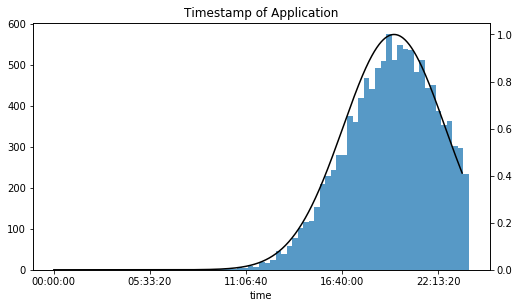

In [1703]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax3.hist(hours, bins=50, alpha=0.75)
ax4.plot(x*85000, timestamp(x), '-k')

ax3.set_title('Timestamp of Application')
ax4.set_ylim(0,)
plt.show()

In [1704]:
print timedelta(days = int(-generateDistribution(daysBeforeApproval) * 60))
print timedelta(hours = generateDistribution(timestamp) * 24)

-9 days, 0:00:00
22:04:30.893617


The plots below show the functions to generate the channels from, and the actual generated data. Because the numbers are relatively low, the data does not follow the functions too well on first sight.

In [1705]:
def channelFunction(x):
    return [logit(x, 0.5, -200, 0.70, -0.10),
            logit(x, 0.5, -200, 0.25, 0.05),
            logit(x, 0.5, -200, 0.05, 0.05)]

In [1706]:
def channelValues(channel):
    l = []
    for month in range(1, 13):
        monthlyData = approvals[approvals.date.map(lambda x: x.month == month and x.year == 2016)]
        l.append(np.mean(monthlyData.channel==channel))
    return l

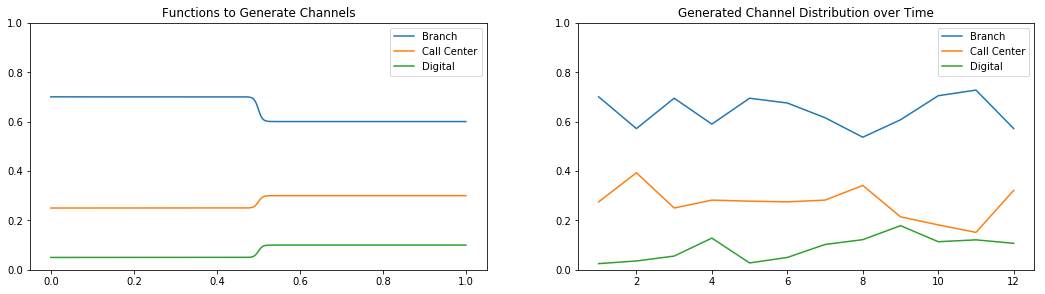

In [1707]:
channels = ['Branch', 'Call Center', 'Digital']
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax1.set_ylim(0,1)
ax2 = fig.add_subplot(222); ax2.set_ylim(0,1)
xPoints1 = np.linspace(0, 1, num=1000)
xPoints2 = np.arange(1, 13, dtype=float)
for i, c in enumerate(channels):
    ax1.plot(xPoints1, channelFunction(xPoints1)[i], label=c)
    ax2.plot(xPoints2, channelValues(c), label=c)
ax1.set_title('Functions to Generate Channels')
ax2.set_title('Generated Channel Distribution over Time')
ax1.legend(); ax2.legend(); plt.show()

However, if we take the mean of channel values in the first five months and the last five months, we can see in the pie charts below that the percentages approach the numbers asked for.

In [1708]:
pre = [np.mean(channelValues('Branch')[:5]),
       np.mean(channelValues('Call Center')[:5]),
       np.mean(channelValues('Digital')[:5])]
post = [np.mean(channelValues('Branch')[7:]), 
        np.mean(channelValues('Call Center')[7:]),
        np.mean(channelValues('Digital')[7:])]

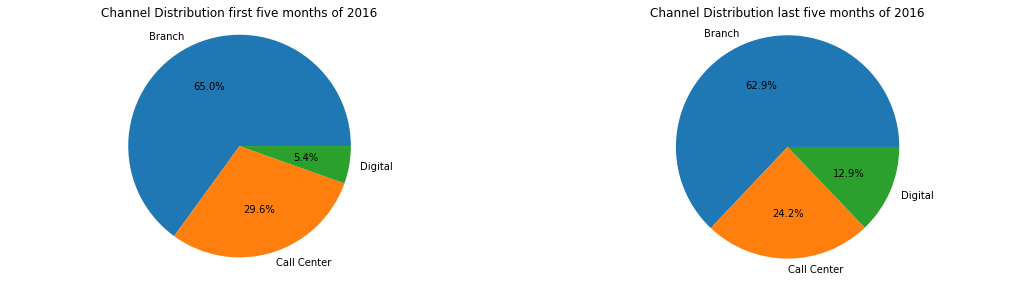

In [1709]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.pie(pre, labels=channels, autopct='%1.1f%%')
ax2.pie(post, labels=channels, autopct='%1.1f%%')
ax1.set_title('Channel Distribution first five months of 2016')
ax2.set_title('Channel Distribution last five months of 2016')
ax2.axis('equal'); ax1.axis('equal')
plt.show()

In [1710]:
generations = []
time = np.linspace(0, 1, num=10000)
for i, x in enumerate(time):
    generations.append(np.random.choice(channels, p=channelFunction(i)))

In [1711]:
np.array(generations)

array(['Branch', 'Branch', 'Branch', ..., 'Digital', 'Call Center',
       'Branch'], 
      dtype='|S11')

## Attribution

In [1732]:
approvals.head()

,id,date,time,goal,subgoal,channel,status,dayOfYear,itx,sim,dig
0,2,2014-12-20,23:04:16.901997,Goal,Subgoal,Branch,Approved,353,32,4,270
2,10,2015-02-12,22:11:19.170654,Goal,Subgoal,Digital,Approved,42,22,3,72
3,11,2015-11-06,23:35:23.248694,Goal,Subgoal,Branch,Approved,309,28,3,247
4,15,2016-06-23,17:57:51.824622,Goal,Subgoal,Call Center,Approved,174,21,3,99
6,20,2016-12-04,16:16:25.838134,Goal,Subgoal,Branch,Approved,338,30,3,244


In [1748]:
differences = (datetime(2016, 6, 1) - approvals.date).apply(lambda x: x.days).values
last90Days = approvals[(differences < 90) & (differences > 0)]
last90Days.head()

,id,date,time,goal,subgoal,channel,status,dayOfYear,itx,sim,dig
13,46,2016-03-11,17:33:20.552842,Goal,Subgoal,Branch,Approved,70,20,2,46
15,48,2016-04-04,21:26:27.131561,Goal,Subgoal,Branch,Approved,94,23,3,89
62,161,2016-05-12,17:02:49.247267,Goal,Subgoal,Call Center,Approved,132,19,2,91
131,339,2016-03-13,18:43:41.187590,Goal,Subgoal,Call Center,Approved,72,20,2,47
198,502,2016-05-06,20:10:56.407256,Goal,Subgoal,Call Center,Approved,126,21,3,103


## 3.2 Digital Interactions - Page Visits & Simulations

Below, some of the digital interactions are shown for illustration.

In [1713]:
digitalsfile = 'Digitals.csv'
names = pd.read_csv(basepath+'Digitals.hdr', sep=';')
digitals = pd.read_csv(basepath+digitalsfile, sep=';', names=names)
digitals.loc[:,'date'] = digitals.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
digitals.loc[:,'time'] = digitals.time.apply(lambda x: striptime(x))
digitals['dayOfYear'] = digitals.date.map(lambda x: int(x.strftime('%j')) - 1)

In [1714]:
print(len(digitals))
digitals.head(10)

427598


,id,date,time,goal,subgoal,channel,days,dayOfYear
0,2,2014-12-06,18:58:47.065542,Goal,Subgoal,Page Visit,-14,339
1,2,2014-12-20,21:41:21.627302,request information,run simulation,Simulation,0,353
2,2,2014-12-20,11:48:06.968314,Goal,Subgoal,Page Visit,0,353
3,2,2014-12-03,19:26:40.364921,request information,run simulation,Simulation,-17,336
4,2,2014-12-03,05:15:17.283778,Goal,Subgoal,Page Visit,-17,336
5,2,2014-12-06,17:01:41.645010,request information,run simulation,Simulation,-14,339
6,2,2014-12-06,12:45:17.270009,Goal,Subgoal,Page Visit,-14,339
7,2,2014-11-27,14:37:40.252051,request information,run simulation,Simulation,-23,330
8,2,2014-11-27,11:45:03.747199,Goal,Subgoal,Page Visit,-23,330
9,2,2014-11-25,09:12:44.529508,Goal,Subgoal,Page Visit,-25,328


The plots below show the number of days of a digital interaction before the application of the car loan (left), and the time of the interaction (right).

In [1715]:
def timestamp(x):
    gauss1 = gauss(x, position = 1 / 3., deviation = 0.05, height = 0, altitude = 1)
    gauss2 = gauss(x, position = 0.5, deviation = 0.25, height = 0, altitude = 1.1)
    return (gauss1 + gauss2) / 1.9

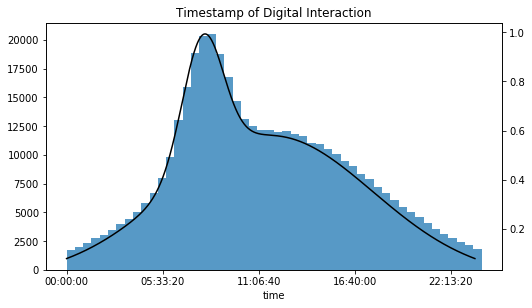

In [1716]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(222); ax2 = ax1.twinx()
ax1.hist(digitals.time.values, bins=50, alpha=0.75)
ax2.plot(x*85000, timestamp(x), '-k')
ax1.set_title('Timestamp of Digital Interaction')
plt.show()

The plot below shows the functions to generate the number of digital interactions per customer (left) and the actual generated number of digital interactions per customer.

In [1717]:
def numberOfPageVisits(x):
    return logit(x, position=0.65, spread=-20, setoff=10, altitude=15)

def numberOfSimulations(x):
    return logit(x, position=0.65, spread=-20, setoff=2, altitude=1)

def numberOfNonCarLoaners(x):
    return logit(x, position=0.65, spread=-20, setoff=85, altitude=180)

def numberOfTotalDigitals(x):
    return numberOfPageVisits(x) + numberOfSimulations(x) + numberOfNonCarLoaners(x)

In [1718]:
datetime(2016, 1, 1) + timedelta(days = np.random.rand()*365)

datetime.datetime(2016, 12, 18, 20, 39, 53, 383097)

In [1719]:
numberOfItx = pd.DataFrame(digitals[(digitals.channel=='Page Visit')].groupby(['id']).size(), columns=['itx'])
numberOfSim = pd.DataFrame(digitals[(digitals.channel=='Simulation')].groupby(['id']).size(), columns=['sim'])
numberOfDig = pd.DataFrame(digitals[digitals.channel=='Digital'].groupby(['id']).size(), columns=['dig'])
approvals = pd.merge(approvals, numberOfItx, left_on='id', right_index=True, how='left')
approvals = pd.merge(approvals, numberOfSim, left_on='id', right_index=True, how='left')
approvals = pd.merge(approvals, numberOfDig, left_on='id', right_index=True, how='left')
#approvals = approvals.fillna(0)

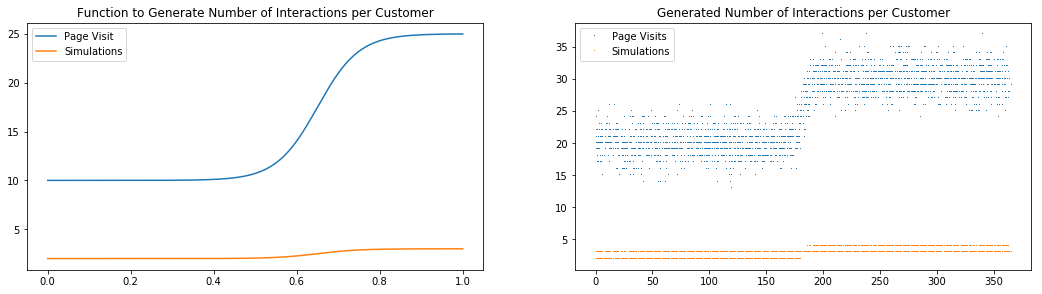

In [1720]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfPageVisits(x), label = 'Page Visit')
ax1.plot(x, numberOfSimulations(x), label = 'Simulations')
ax2.plot(approvals.dayOfYear, approvals.itx, ',', label='Page Visits')
ax2.plot(approvals.dayOfYear, approvals.sim, ',', label='Simulations')
ax1.set_title('Function to Generate Number of Interactions per Customer')
ax2.set_title('Generated Number of Interactions per Customer')
ax1.legend(); ax2.legend()
plt.show()

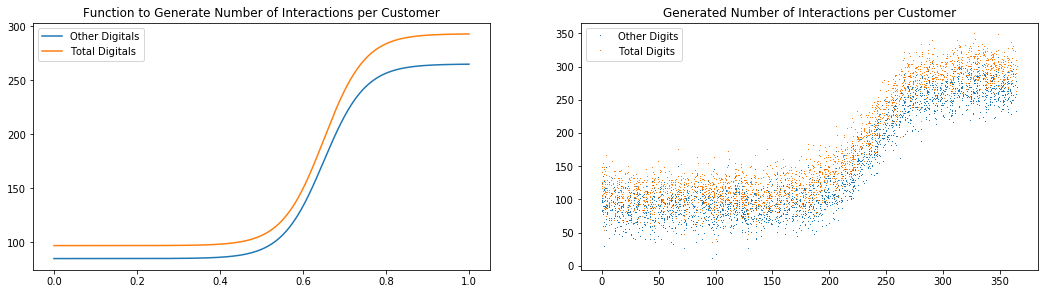

In [1721]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfNonCarLoaners(x), label = 'Other Digitals')
ax1.plot(x, numberOfTotalDigitals(x), label = 'Total Digitals ')
ax2.plot(approvals.dayOfYear, approvals.dig, ',', label='Other Digits')
ax2.plot(approvals.dayOfYear, approvals.itx + approvals.sim + approvals.dig, ',', label='Total Digits')
ax1.set_title('Function to Generate Number of Interactions per Customer')
ax2.set_title('Generated Number of Interactions per Customer')
ax1.legend(); ax2.legend()
plt.show()

### Simulation Distribution

In [1722]:
digitalSims = approvals[approvals.channel == 'Digital'].sim

In [1723]:
percentages = []
percentages.append(np.mean(digitalSims == 1))
percentages.append(np.mean(digitalSims == 2))
percentages.append(np.mean(digitalSims == 3))
percentages.append(np.mean(digitalSims > 3))

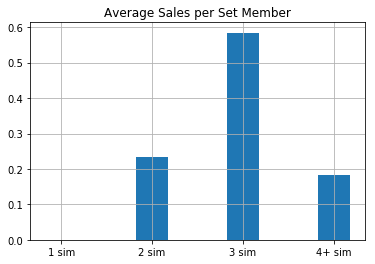

In [1724]:
ind = np.arange(4)
width = 0.35
plt.grid(True)
plt.bar(ind + width, percentages, width)
plt.xticks(ind+width, ('1 sim', '2 sim', '3 sim', '4+ sim'))
plt.title('Average Sales per Set Member')
plt.show()

In [1725]:
percentages

[0.0, 0.23239436619718309, 0.58450704225352113, 0.18309859154929578]

### Non Car Loan Simulations

In [1726]:
numberOfSimNC = pd.DataFrame(digitals[(digitals.channel=='Simulation') & (digitals.status=='No Car Loan')].groupby(['id']).size(), columns=['sim'])
numberOfSimNC.head()

AttributeError: 'DataFrame' object has no attribute 'status'

In [1727]:
print sum(numberOfSim.sim==1), sum(numberOfSimNC.sim==1), (1 - 0.0625) / 0.0625 * sum(numberOfSim.sim==1)
print sum(numberOfSim.sim==2), sum(numberOfSimNC.sim==2), (1 - 0.2) / 0.2 * sum(numberOfSim.sim==2)
print sum(numberOfSim.sim==3), sum(numberOfSimNC.sim==3), (1 - 0.2) / 0.2 * sum(numberOfSim.sim==3)
print sum(numberOfSim.sim >3), sum(numberOfSimNC.sim >3), (1 - 0.05) / 0.05 * sum(numberOfSim.sim>3)

0 1849 0.0
723 11021 2892.0
1251 11106 5004.0
452 2780 8588.0


In [1728]:
percentages = []
percentages.append(sum(numberOfSim.sim==1) / float(sum(numberOfSimNC.sim==1) + sum(numberOfSim.sim==1)))
percentages.append(sum(numberOfSim.sim==2) / float(sum(numberOfSimNC.sim==2) + sum(numberOfSim.sim==2)))
percentages.append(sum(numberOfSim.sim==3) / float(sum(numberOfSimNC.sim==3) + sum(numberOfSim.sim==3)))
percentages.append(sum(numberOfSim.sim >3) / float(sum(numberOfSimNC.sim >3) + sum(numberOfSim.sim >3)))

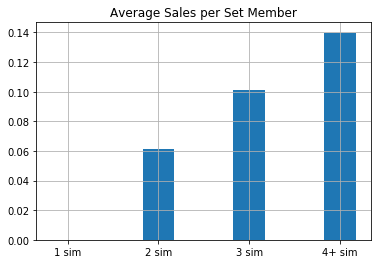

In [1729]:
ind = np.arange(4)
width = 0.35
plt.grid(True)
plt.bar(ind + width, percentages, width)
plt.xticks(ind+width, ('1 sim', '2 sim', '3 sim', '4+ sim'))
plt.title('Average Sales per Set Member')
plt.show()

In [1730]:
percentages

[0.0, 0.061563351498637599, 0.101238164603059, 0.13985148514851486]

## 3.3 Channel Branch

Below, some of the branch interactions are shown for illustration.

In [654]:
branchfile = 'Branches.csv'
names = pd.read_csv(basepath+'Branches.hdr', sep=';')
branches = pd.read_csv(basepath+branchfile, sep=';', names=names)
branches.loc[:,'date'] = branches.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
branches.loc[:,'time'] = branches.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())

In [655]:
print(len(branches))
branches.head()

8795


,id,date,time,goal,subgoal,channel,days
0,2,2016-04-24,07:54:05.298809,Goal,Subgoal,Branch,-16
1,6,2013-03-09,02:07:22.003162,Goal,Subgoal,Branch,-4
2,11,2016-05-24,16:57:05.975244,Goal,Subgoal,Branch,-25
3,16,2016-04-17,13:25:41.728162,Goal,Subgoal,Branch,-13
4,20,2016-03-17,13:02:31.023040,Goal,Subgoal,Branch,0


The plots below show the number of days of a branch interaction before the application of the car loan (left), and the time of the interaction (right).

In [656]:
def daysBeforePurchase(x):
    return gauss(x, position = 0, deviation = .85, height = -.5, altitude = 2)

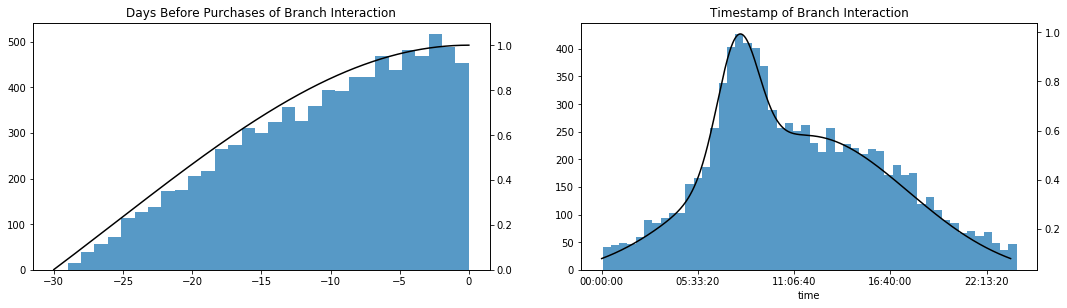

In [657]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = ax1.twinx()
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax1.hist(branches.days, bins=30, alpha=0.75)
ax3.hist(branches.time.values, bins=50, alpha=0.75)
ax2.plot(x*-30, daysBeforePurchase(x), '-k')
ax4.plot(x*85000, timestamp(x), '-k')

ax1.set_title('Days Before Purchases of Branch Interaction')
ax3.set_title('Timestamp of Branch Interaction')
ax2.set_ylim(0,1.1)
plt.show()

The plot below shows the functions to generate the number of branch interactions per customer (left) and the actual generated number of branch interactions per customer.

In [658]:
def numberOfBranches(x):
    return logit(x, position=0.5, spread=100, setoff=.5, altitude=.5)

In [659]:
numberOfBra = pd.DataFrame(branches.groupby(['id']).size(), columns=['bra'])
approvals = pd.merge(approvals, numberOfBra, left_on='id', right_index=True, how='left')
approvals.bra = approvals.bra.apply(lambda x: 0 if np.isnan(x) else x)

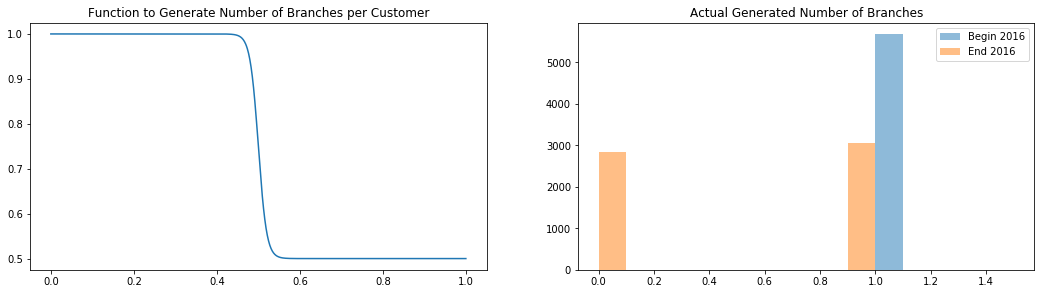

In [667]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
pre2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 < 182)].bra
post2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 > 183)].bra
ax1.plot(x, numberOfBranches(x))
ax2.hist(pre2016, alpha=0.5, label='Begin 2016');ax2.hist(post2016, alpha=0.5, label='End 2016')
ax1.set_title('Function to Generate Number of Branches per Customer')
ax2.set_title('Actual Generated Number of Branches'); ax2.legend()
plt.show()

## 3.4 Channel Call Center

Below, some of the call center interactions are shown for illustration.

In [128]:
callcenterfile = 'callcenter.csv'
names = pd.read_csv(basepath+'callcenter.hdr', sep=';')
callcenters = pd.read_csv(basepath+callcenterfile, sep=';', names=names)
callcenters.loc[:,'date'] = callcenters.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
callcenters.loc[:,'time'] = callcenters.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())

In [129]:
print(len(callcenters))
callcenters.head()

6010


,id,date,time,goal,subgoal,channel,days
0,2,2016-08-28,06:46:10.829261,Subgoal,Digital,Call Center,-1
1,21,2010-09-09,08:58:12.070000,Subgoal,Digital,Call Center,-14
2,27,2013-07-22,12:10:30.564838,Subgoal,Digital,Call Center,-4
3,31,2013-11-27,08:33:41.245158,Subgoal,Digital,Call Center,-16
4,36,2014-10-06,14:06:43.848348,Subgoal,Digital,Call Center,-12


The plots below show the number of days of a call center interaction before the application of the car loan (left), and the time of the interaction (right).

In [130]:
def daysBeforePurchase(x):
    return gauss(x, position = 1/3., deviation = .56, height = -.5, altitude = 2)

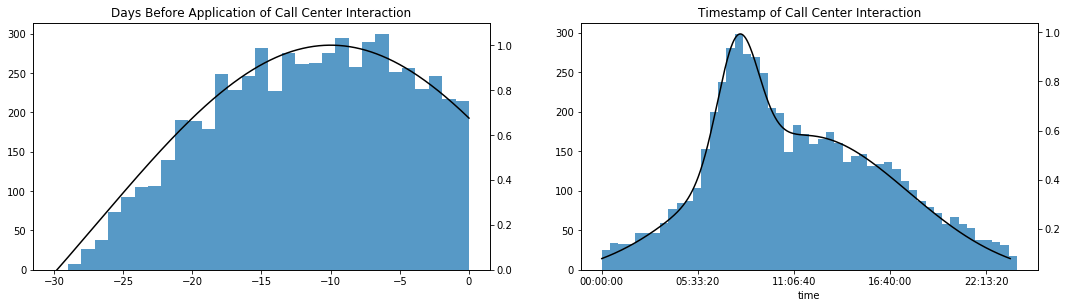

In [131]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = ax1.twinx()
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax1.hist(callcenters.days, bins=30, alpha=0.75)
ax3.hist(callcenters.time.values, bins=50, alpha=0.75)
ax2.plot(x*-30, daysBeforePurchase(x), '-k')
ax4.plot(x*85000, timestamp(x), '-k')

ax1.set_title('Days Before Application of Call Center Interaction')
ax3.set_title('Timestamp of Call Center Interaction')
ax2.set_ylim(0,1.1)
plt.show()

The plot below shows the functions to generate the number of call center interactions per customer (left) and the actual generated number of call center interactions per customer.

In [132]:
def numberOfCallCenters(x):
    return logit(x, position=0.5, spread=-100, setoff=.25, altitude=.5)

In [670]:
numberOfCal = pd.DataFrame(callcenters.groupby(['id']).size(), columns=['cal'])
approvals = pd.merge(approvals, numberOfCal, left_on='id', right_index=True, how='left')
approvals.cal = approvals.cal.apply(lambda x: 0 if np.isnan(x) else x)

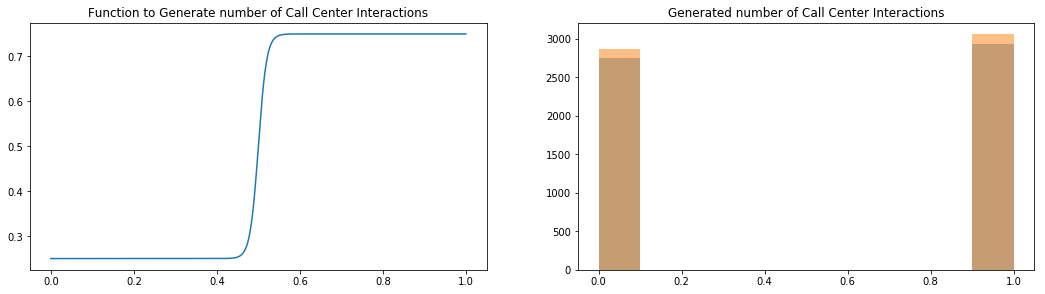

In [672]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
pre2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 < 182)].cal
post2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 > 183)].cal
ax1.plot(x, numberOfCallCenters(x))
ax2.hist(pre2016, alpha=0.5, label='Begin 2016');ax2.hist(post2016, alpha=0.5, label='End 2016')
ax1.set_title('Function to Generate number of Call Center Interactions')
ax2.set_title('Generated number of Call Center Interactions')
plt.show()

Percentage Checks.

In [139]:
pre2016 = approvals[approvals.dayOfYear < 100]
post2016 = approvals[approvals.dayOfYear > 265]

In [140]:
print 'Should be 10 and 25:', pre2016.itx.mean(), post2016.itx.mean()
print 'Should be 2 and 4:', pre2016.sim.mean(), post2016.sim.mean()
print 'Should be 1 and 0.5:', pre2016.bra.mean(), post2016.bra.mean()
print 'Should be 0.25 and 0.75', pre2016.cal.mean(), post2016.cal.mean()

Should be 10 and 25: 9.97329773031 25.0352941176
Should be 2 and 4: 1.99665998664 4.00959752322
Should be 1 and 0.5: 1.0 0.492879256966
Should be 0.25 and 0.75 0.0 1.0


## 3.5 Refusals and Complaints

Below, some of the refusal & complaint interactions are shown for illustration.

In [141]:
basepath = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/'
complaintsFile = 'complaints.csv'
names = pd.read_csv(basepath+'complaints.hdr', sep=';')
complaintsCarLoans = pd.read_csv(basepath+complaintsFile, sep=';', names=names)
complaintsCarLoans.loc[:,'date'] = complaintsCarLoans.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [142]:
print 'Number of rejections:', len(rejectedCarloans)
rejectedCarloans.head(10)

Number of rejections: 6063


,id,date,time,goal,subgoal,channel,status,dayOfYear
1,3,2016-07-09,07:07:34.517290,Goal,Subgoal,Call Center,Rejected,190
2,5,2016-07-06,02:52:55.181833,Goal,Subgoal,Call Center,Rejected,187
4,9,2012-11-13,11:19:01.828993,Goal,Subgoal,Digital,Rejected,317
7,17,2012-11-12,00:09:25.598298,Goal,Subgoal,Branch,Rejected,316
12,28,2015-05-20,07:13:00.086434,Goal,Subgoal,Branch,Rejected,139
14,30,2010-06-23,11:13:56.215150,Goal,Subgoal,Digital,Rejected,173
19,38,2012-06-09,22:14:19.759186,Goal,Subgoal,Branch,Rejected,160
20,43,2012-04-14,06:24:11.748832,Goal,Subgoal,Branch,Rejected,104
21,45,2016-06-30,09:20:42.100509,Goal,Subgoal,Call Center,Rejected,181
25,49,2016-07-02,08:50:11.625708,Goal,Subgoal,Branch,Rejected,183


In [143]:
print 'Number of complaints:', len(complaintsCarLoans)
complaintsCarLoans.head(10)

Number of complaints: 64


,id,date,time,goal,subgoal,channel
0,240,2016-06-26,7:51:03.722155,Goal,Subgoal,Branch
1,245,2016-07-12,6:37:01.698152,Goal,Subgoal,Call Center
2,906,2016-06-11,10:02:49.399035,Goal,Subgoal,Branch
3,1674,2015-01-05,23:19:20.511876,Goal,Subgoal,Branch
4,2121,2016-08-20,3:33:55.363457,Goal,Subgoal,Call Center
5,2257,2015-05-31,14:26:57.341682,Goal,Subgoal,Call Center
6,2638,2016-07-15,1:20:03.618329,Goal,Subgoal,Call Center
7,3990,2015-03-01,14:55:52.218255,Goal,Subgoal,Branch
8,4243,2016-07-21,13:52:59.572169,Goal,Subgoal,Branch
9,4287,2013-12-30,7:26:42.014449,Goal,Subgoal,Branch


The plots below show the number of total, approved and rejected car loan applications (left) and the share of approved and rejected applications, with respect to the total number of applications (right).

In [144]:
approvals = createBins(approvals, databins, 'date')
rejections = createBins(rejectedCarloans, databins, 'date')
complaints = createBins(complaintsCarLoans, databins, 'date')
applications = approvals + rejections

In [145]:
rejectionsShare = rejections / applications
approvalShare = approvals / applications
complaintsShare = complaints / applications

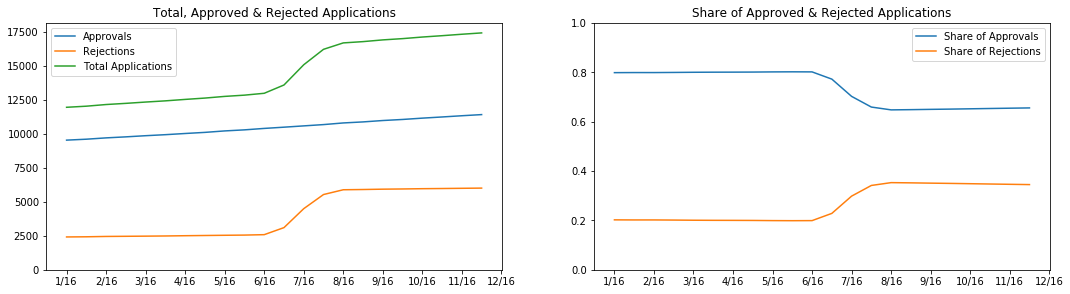

In [146]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, approvals, label='Approvals')
ax1.plot(x, rejections, label='Rejections')
ax1.plot(x, applications, label = 'Total Applications')
ax2.plot(x, approvalShare, label='Share of Approvals')
ax2.plot(x, rejectionsShare, label='Share of Rejections')
ax1.set_title('Total, Approved & Rejected Applications')
ax2.set_title('Share of Approved & Rejected Applications')
ax1.legend(); ax2.legend(); ax1.set_ylim(0,); ax2.set_ylim(0,1)
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
plt.show()

In [147]:
rejectionsShare[0], rejectionsShare[-1]

(0.20212765957446807, 0.34484542006665903)

The plots below show the number of complaints (left) and the share of complaints, with respect to the total number of refusals (right).

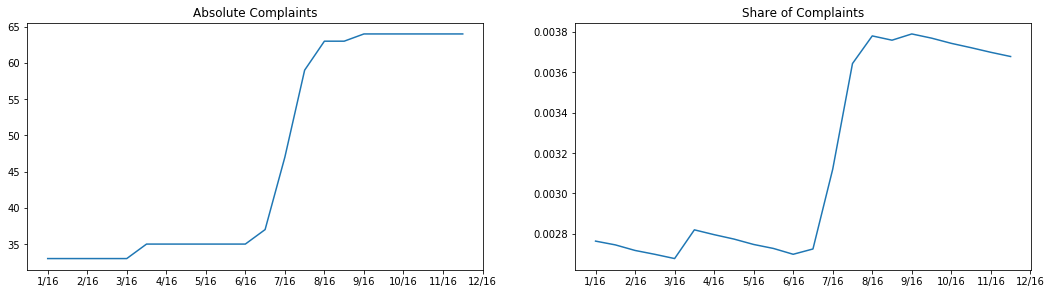

In [148]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, complaints); ax2.plot(x, complaintsShare)
ax1.set_title('Absolute Complaints'); ax2.set_title('Share of Complaints')
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
plt.show()

# 4. Data Ingest in Lily

## Data on Cluster

Csv files on cluster are identical.

## Dataframe in Lily

Print out first rows of dataframe.

In [ ]:
basepath = '/Users/desiredewaele/Desktop/Car Loan Test 2016/'
names = pd.read_csv(basepath+'dataframe_columns.csv', sep='|')
data = pd.read_csv(basepath+'dataframe.csv', sep='|', names=names.name)
data.head(10)

3 customer ids in dataframe

In [ ]:
data[data.originalSourceIds.isin(['[""CRM:6""]', '[""CRM:9937""]', '[""CRM:49458""]'])]

same 3 customerids in product table

In [ ]:
productData[(productData.PRODUCT == 'Car Loan') & (productData.ID.isin([6, 9937, 49458]))]

In [ ]:
len(data[-np.isnan(data.marginCarLoans)]), len(productData[(productData.PRODUCT == 'Car Loan')])

Compare means (excluding non-nan's) with expected values according to functions above. These behave as expected.

In [ ]:
timeX = 2484 / (7.*365) # Normalized day number of 2016-10-20
print 'Margin:', data.marginCarLoans.mean(), 'should be', margin(timeX) + noise(timeX)
print 'Rate:  ', data.rateCarLoans.mean(), 'should be', rate(timeX) + noise(timeX)
print 'Value: ', data.valueCarLoans.mean(), 'should be', value(timeX) + noise(timeX)
print 'Credit:', data.creditCarLoans.mean(), 'should be', credit(timeX) + noise(timeX)

In [ ]:
plt.pie(data.remainingYearsCarLoan.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Compare means (including non-nan's with default value 0) with expected values according to functions above. These numbers are shown by the Lily widgets.

In [ ]:
data.marginCarLoans = data.marginCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.rateCarLoans = data.rateCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.valueCarLoans = data.valueCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.creditCarLoans = data.creditCarLoans.apply(lambda x: 0 if np.isnan(x) else x)

In [ ]:
print 'Margin:', data.marginCarLoans.mean(), 'should be', margin(timeX) + noise(timeX)
print 'Rate:  ', data.rateCarLoans.mean(), 'should be', rate(timeX) + noise(timeX)
print 'Value: ', data.valueCarLoans.mean(), 'should be', value(timeX) + noise(timeX)
print 'Credit:', data.creditCarLoans.mean(), 'should be', credit(timeX) + noise(timeX)